# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
# pip install git+https://github.com/alemartinello/dstapi
from dstapi import DstApi

import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from IPython.display import display,clear_output
import matplotlib.pyplot as plt
import matplotlib
import time

import pandas as pd

# user written modules
# import dataproject


# Read and clean data

The first data set we import is the population by age for each municipality in Denmark

In [2]:
ind = DstApi('FOLK1A') # connecting to dst API
tabsum = ind.tablesummary(language='en')
tabsum  # presenting summary of data

Table FOLK1A: Population at the first day of the quarter by region, sex, age, marital status and time
Last update: 2023-02-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,105,000,All Denmark,851,Aalborg,False
1,KØN,3,TOT,Total,2,Women,False
2,ALDER,127,IALT,Total,125,125 years,False
3,CIVILSTAND,5,TOT,Total,F,Divorced,False
4,Tid,61,2008K1,2008Q1,2023K1,2023Q1,True


In [3]:
# we are only interested in municipalities and not regions, so we loop thrugh all variables
# in 'OMRÅDER' and store the ID of municipalities
kom = []
for row, value in zip(ind.variable_levels('OMRÅDE')['id'],ind.variable_levels('OMRÅDE')['text']):
    if 'Region' not in value:
            kom.append(row)

# importing data
params = {'table':'FOLK1A',
         'format':"BULK",
         'variables':[{'code':'OMRÅDE','values':['*']},
                     {'code':'KØN','values':['*']},
                     {'code':'ALDER','values':['*']},
                     {'code':'Tid','values':['*']},
                     {'code':'CIVILSTAND','values':['TOT']}]}
data = ind.get_data(params)

In [4]:
# cleaning the data

# the data is quartlery and set up as YYYYKX, we change the K to a Q such as it can be converted to datetime 
data['TID'] = pd.to_datetime(data.reset_index()['TID'].apply(lambda x: x.replace('K','Q')))
# keep a selected number of columns
data = data[data['KØN']=='I alt'][['TID','OMRÅDE','ALDER','INDHOLD']]
# create column with the yearly value
data['ÅR'] = data['TID'].dt.year
# discard the three other quarterly observations
data = data.groupby(['ÅR','OMRÅDE','ALDER']).last()
# reset index
data = data.reset_index()
# dropping the original time denomination
data = data.drop(columns = ['TID'])
# convert the yearly column into integer type
data['ÅR'] = data['ÅR'].astype(int)
# discar the total population in each municipality
data = data[data['ALDER'] != 'I alt']
# convert age column into integers
data['ALDER'] = data['ALDER'].str.strip(' år')
data['ALDER'] = data['ALDER'].astype(int)

The second data set we import is the health care expenditures for each danish municipality from 2008-2022

In [5]:
# connecting to dst
ind = DstApi('REGK11')

# choosing which variables to import
params = {'table':'REGK11',
        'format':"BULK",
        'variables':[{'code':'OMRÅDE','values':['*']},
                    {'code':'PRISENHED','values':['INDL']},
                    {'code':'DRANST','values':['1']},
                    {'code':'FUNK1','values':['4']},
                    {'code':'ART','values':['TOT']},
                    {'code':'TID','values':['>2007']}]}
# importing data
HC_EXP = ind.get_data(params)

# dropping irrelevant and/or constant columns
HC_EXP.drop(columns=['PRISENHED', 'DRANST', 'FUNK1', 'ART'],inplace=True)

# renaming columns
HC_EXP.rename(columns={'INDHOLD':'SUNDHEDSUDGIFTER'},inplace=True)

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

In [6]:
# renaming to merge later
HC_EXP.rename(columns={'TID':'ÅR'},inplace=True)
# merging on municipality and year, we discard all non-municpality observations in HC_EXP
new_df = pd.merge(data, HC_EXP,  how='left', left_on=['OMRÅDE','ÅR'], right_on = ['OMRÅDE','ÅR'])
# calculating the total population in each municipality
samlet_bef = new_df.groupby(['ÅR','OMRÅDE'])['INDHOLD'].sum()
# creaing new column for old people for convenience
new_df['GAMLE'] = new_df['INDHOLD']
new_df.loc[new_df['ALDER']<60,'GAMLE'] = 0
# calculating the total number of old people in each municipality
samlet_bef1 = new_df.groupby(['ÅR','OMRÅDE'])['GAMLE'].sum()
df_ = pd.merge(samlet_bef, samlet_bef1,  how='left', left_on=['OMRÅDE','ÅR'], right_on = ['OMRÅDE','ÅR'])
df_['ANDEL'] = df_['GAMLE']/df_['INDHOLD']
# renaming columns and creating final merging
df_.rename(columns={'INDHOLD':'SAMLET BEFOLKNING'},inplace=True)
df_ = pd.merge(df_,HC_EXP,how='left', left_on=['OMRÅDE','ÅR'], right_on = ['OMRÅDE','ÅR'])

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [7]:
def plot_graph1(change=None):
    plot_graph_1(output_widget)

def plot_graph2(change=None):
    plot_graph_2(output_widget2)

def plot_graph_1(output):
    year = year_slider.value
    municipal = municipal_slider.value
    
    # Filter the DataFrame based on the selected year and municipal
    filtered_df = data[data['ÅR'] == year]
    filtered_df = filtered_df[filtered_df['OMRÅDE'].isin(municipal)]

    # Create the bar plot
    plt.barh(filtered_df['ALDER'].unique(), filtered_df['INDHOLD'])
    plt.title(f"Values for year {year}")
    plt.xlabel("Antal")
    plt.ylabel("År")
    plt.tight_layout()

    # Display the graph in the output widget
    with output:
        output.clear_output(wait=True)
        display(plt.gcf())
        
    plt.clf()
    
def plot_graph_2(output):

    year = year_slider.value
    municipal = municipal_slider.value
    
    filtered_df = df_[df_['OMRÅDE'].isin(municipal)]
    
    xx = filtered_df['ANDEL']
    yy = filtered_df['SUNDHEDSUDGIFTER']
    
    plt.scatter(xx,yy)

    for i, txt in enumerate(filtered_df['ÅR'].unique()):
        plt.annotate(txt, (xx.values[i], yy.values[i]))
    plt.xlabel('Share of population $\geq$60 years')
    plt.ylabel('Health care expenditure per capita, DKK')
    ax = plt.gca()
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
    with output:
        output.clear_output(wait=True)
        display(plt.gcf())

        
    plt.clf()

# Create the year slider
year_slider = widgets.IntSlider(
    value=data['ÅR'].min(),
    min=data['ÅR'].min(),
    max=data['ÅR'].max(),
    step=1,
    description="Year:",
    continuous_update=True,
)

# Create the municipal slider
municipal_slider = widgets.SelectMultiple(
    options=data['OMRÅDE'].unique(),
    value=['Ærø'],
    description='Municipal:',
    disabled=False,
)

# Create the output widgets
output_widget = widgets.Output()
output_widget2 = widgets.Output()

# Observe the slider changes and update the graphs
year_slider.observe(plot_graph1, names='value')
municipal_slider.observe(plot_graph1, names='value')

year_slider.observe(plot_graph2, names='value')
municipal_slider.observe(plot_graph2, names='value')

# Create a 2x2 GridBox layout
layout = widgets.GridBox(
    children=[year_slider, municipal_slider, output_widget, output_widget2],
    layout=widgets.Layout(
        width='100%',
        grid_template_columns='50% 50%',
        grid_template_rows='25% 50%',
        grid_gap='10px',
        grid_template_areas='''
            "year_slider municipal_slider"
            "output_widget output_widget2"
        ''')
)

# Initialize the graphs
plot_graph1()
plot_graph2()

# Display the GridBox layout
display(layout)


GridBox(children=(IntSlider(value=2008, description='Year:', max=2023, min=2008), SelectMultiple(description='…

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Explain what you see when moving elements of the interactive plot around. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

vil du lave en tabel med nogle deskriptive tal omkring vores datasæt og en figur der sammenligner en hovedstadskommune og Langeland.



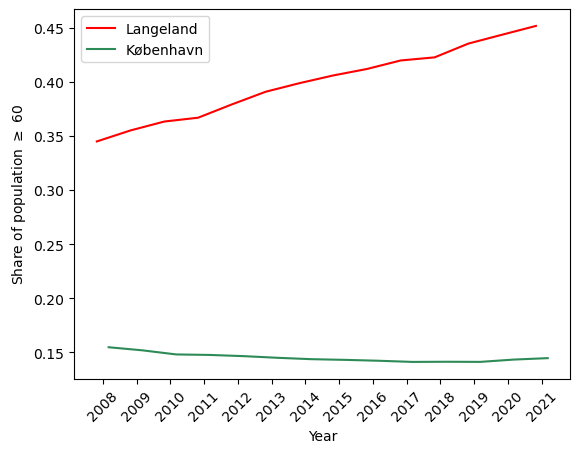

In [47]:
# Comparing two municipalities 
df_lang = df_.loc[df_["OMRÅDE"] == "Langeland"]
df_kob = df_.loc[df_["OMRÅDE"] == "København"]

df_lang = df_lang[:-2]
df_kob = df_kob[:-2]

N = len(df_lang["ÅR"])

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
l = ax.plot(ind, df_lang["ANDEL"], width, color='red')
k = ax.plot(ind+width, df_kob["ANDEL"], width, color='seagreen')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels( df_lang["ÅR"])

ax.legend( (l[0], k[0]), ('Langeland', 'København'))

ax.tick_params(axis='x', rotation=45)

plt.xlabel("Year")
plt.ylabel("Share of population $\geq$ 60")

plt.show()


MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

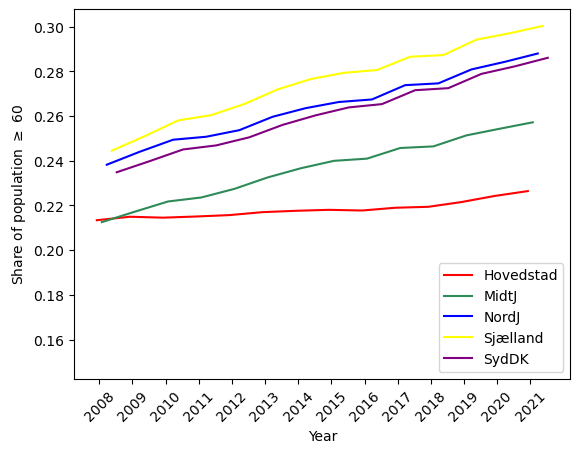

In [55]:
#Comparing the 5 regions
df_regh = df_.loc[df_["OMRÅDE"] == "Region Hovedstaden"]
df_regmj = df_.loc[df_["OMRÅDE"] == "Region Midtjylland"]
df_regnj = df_.loc[df_["OMRÅDE"] == "Region Nordjylland"]
df_regsj = df_.loc[df_["OMRÅDE"] == "Region Sjælland"]
df_regsy = df_.loc[df_["OMRÅDE"] == "Region Syddanmark"]

df_regh = df_regh[:-2]
df_regmj = df_regmj[:-2]
df_regnj = df_regnj[:-2]
df_regsj = df_regsj[:-2]
df_regsy = df_regsy[:-2]

N = len(df_regh["ÅR"])

ind = np.arange(N)  # the x locations for the groups
width = 0.15       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
h = ax.plot(ind, df_regh["ANDEL"], width, color='red')
mj = ax.plot(ind+width, df_regmj["ANDEL"], width, color='seagreen')
nj = ax.plot(ind+width+width, df_regnj["ANDEL"], width, color='blue')
sj = ax.plot(ind+width+width+width, df_regsj["ANDEL"], width, color='yellow')
sy = ax.plot(ind+width+width+width+width, df_regsy["ANDEL"], width, color='purple')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels( df_regh["ÅR"])

ax.legend( (h[0], mj[0], nj[0], sj[0], sy[0]), ('Hovedstad', 'MidtJ', 'NordJ', 'Sjælland', 'SydDK'))

ax.tick_params(axis='x', rotation=45)

plt.xlabel("Year")
plt.ylabel("Share of population $\geq$ 60")

plt.show()

In [71]:
average = df_['ANDEL'].mean()
print(average)

med = df_['ANDEL'].median()
print(med)

0.2740887099993117
0.2635219544257402


# Conclusion

ADD CONCISE CONLUSION.